In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.plot([0,1], [0,1])
plt.show()
clear_output()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!ls

'ls' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [4]:
import copy
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from utils.helper import set_seed
from utils.xray_plot import draw_pred
import os
import re
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
set_seed(222)
ROOT_FOLDER = "./tensors_padded_updated"

In [6]:
# combining all saved tensors
import torch
ts = []
for file in os.listdir(ROOT_FOLDER):
    if file.endswith(".pt") and re.match(r"^[Xy]_\d+_\d+\.pt$", file):
        ts.append(file)
    if file.endswith(".pt") and re.match(r"^[Xy]_\d+\.pt$", file):
        ts.append(file)
    
ts.sort()
# simple check all x, y are paired
assert len(ts)%2 == 0

ts_x = ts[:len(ts)//2]
ts_y = ts[len(ts)//2:]

X = torch.cat([torch.load(os.path.join(ROOT_FOLDER, t)) for t in ts_x])
y = torch.cat([torch.load(os.path.join(ROOT_FOLDER, t)) for t in ts_y])

In [7]:
# mask out y's that have missing values

mask = torch.isinf(y).any(dim=1)
X = X[~mask]
y = y[~mask]

In [8]:
y.shape #notch--> point; ellipitical--> circle
# 13 

torch.Size([611, 13])

In [9]:
# x shape in the order sample_size*channels*[image_size]
X.shape

torch.Size([611, 3, 256, 256])

In [10]:
# check some example images
idx = random.randint(0, len(y))

tensor([129.1290, 108.8036,  48.0629,  87.4031, 172.2930])


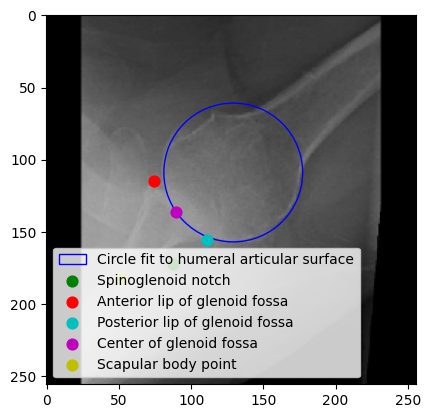

In [11]:
draw_pred(X, y, idx, num_ell=2, num_pts=4)

In [12]:
# data augumentation
# random flip
# 
class XrayDataset(Dataset):
    def __init__(self, x, y ,transform=None):
        self.labels = y
        self.transform = transform
        self.x = x

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.x[idx]
        labels = self.labels[idx, :]
        if self.transform:
            if transform_augument:
                image, labels = transform_augument( (image, labels) )
            image = self.transform(image)
        return [image, labels]

In [31]:
def random_flip(img_labels):
    img, labels = img_labels
    # Randomly decide whether to horizontally flip the image
    if torch.rand(1) < 0.5:
        # Flip the image horizontally
        flipped_img = transforms.functional.hflip(img)
        
        # Adjust the labels
        adjusted_labels = labels.clone()
        adjusted_labels[0] = 256 - adjusted_labels[0] # circle x
        for i in range(3, 13, 2):
            adjusted_labels[i] = 256 -  adjusted_labels[i]

        
        return flipped_img, adjusted_labels
    else:
        # If not flipping, return the original image and labels
        return img, labels

In [32]:
# change this 
# pytorch: flip both 

transform_augument = transforms.Compose([random_flip])

# transform_augument = None

transform_pipeline =  transforms.Compose([
     lambda x: x/255,
                               transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                    ])

In [33]:
full_dataset = XrayDataset(X, y, transform_pipeline)

# set train/val split sizes
split_sizes = [len(X)-len(X)//4, len(X)//4]

train_set, val_set = torch.utils.data.random_split(full_dataset, split_sizes)


In [34]:
def resnet34(outshape):
    resnet = models.resnet34(pretrained=False)
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, outshape)
    return resnet


In [35]:
resnet34_shape=128
output_size=y.shape[1]

In [36]:
pretrained_model = resnet34(output_size)

c:\Users\akame\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akame\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [37]:
# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)

In [40]:
for inputs, targets in val_loader:    
    print(inputs.shape, len(val_loader))

torch.Size([16, 3, 256, 256]) 10
torch.Size([16, 3, 256, 256]) 10
torch.Size([16, 3, 256, 256]) 10
torch.Size([16, 3, 256, 256]) 10
torch.Size([16, 3, 256, 256]) 10
torch.Size([16, 3, 256, 256]) 10
torch.Size([16, 3, 256, 256]) 10
torch.Size([16, 3, 256, 256]) 10
torch.Size([16, 3, 256, 256]) 10
torch.Size([8, 3, 256, 256]) 10


In [22]:
class XrayPretrained(nn.Module):
    def __init__(self):
        super(XrayPretrained, self).__init__()
        self.resnet = pretrained_model # output size = resnet18_shape
        self.fc1=nn.Linear(resnet34_shape,  output_size)

    def forward(self, x):
        x = self.resnet(x)
        return x


model = XrayPretrained().to(device)

In [23]:
criterion = torch.nn.MSELoss()
# weight = (0.5, 0.5, 0.75)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# o.005; 0.0005
# grid search lr; ephoch; Adam....
# stochastic search 
# learning rate scheduler
set_seed(222)


In [24]:
print(len(val_loader), len(y))

10 611


In [25]:
training_loss = []
validation_loss =[]
best_val = float("inf")
best_state = None
best_metrics = None
best_epoch = None
best_state = None

In [26]:
num_epochs = 1000

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    iterations = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print(outputs[0], running_loss)


    # Print average training loss for this epoch
    training_loss.append(running_loss / len(train_loader))


    # Validation phase
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    if total_loss / len(val_loader) < best_val:
        best_val = total_loss / len(val_loader) 
        best_metrics  = (training_loss[-1], best_val)
        best_epoch = epoch
        best_state = copy.deepcopy(model.state_dict())
        print("***************")


    # Print average validation loss for this epoch
    validation_loss.append(total_loss / len(val_loader))
    print(f"Epoch {epoch+1}, Train Loss: {training_loss[-1]}, Val Loss: {validation_loss[-1]}")

print("Training is complete")

***************
Epoch 1, Train Loss: 15770.964069234913, Val Loss: 12589.51982421875
***************
Epoch 2, Train Loss: 9071.687752559268, Val Loss: 6911.215234375
***************
Epoch 3, Train Loss: 4270.061153017241, Val Loss: 2717.79462890625
***************
Epoch 4, Train Loss: 1793.8960423962824, Val Loss: 1449.8068725585938
***************
Epoch 5, Train Loss: 1057.6504116716055, Val Loss: 837.7702941894531
***************
Epoch 6, Train Loss: 787.5079913961476, Val Loss: 788.6403137207031
***************
Epoch 7, Train Loss: 686.7791316591461, Val Loss: 560.7301696777344
Epoch 8, Train Loss: 636.8145783523033, Val Loss: 567.004443359375
***************
Epoch 9, Train Loss: 575.1568761365168, Val Loss: 559.7533477783203
Epoch 10, Train Loss: 578.4565187651535, Val Loss: 648.7413818359375
Epoch 11, Train Loss: 540.1802589153422, Val Loss: 669.0512573242188
Epoch 12, Train Loss: 524.6075776198815, Val Loss: 573.6993988037109
***************
Epoch 13, Train Loss: 560.219536090719

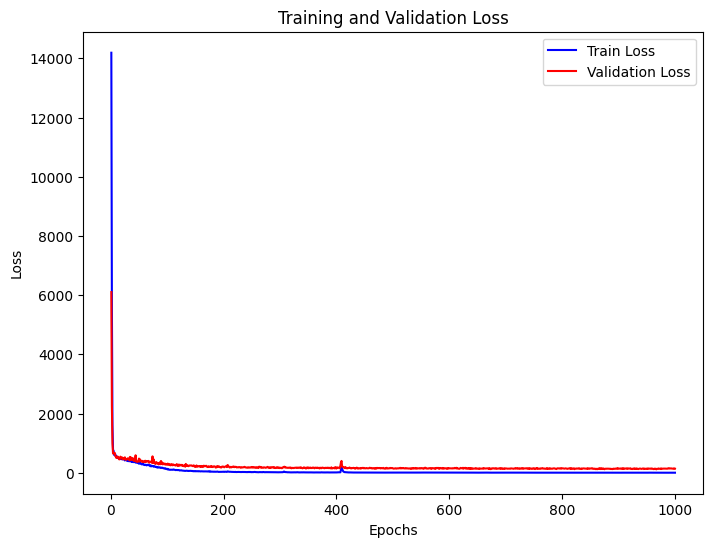

In [189]:
# Create x-axis values (e.g., epochs or time steps)
epochs = range(1, len(training_loss) + 1)

# Plot the train loss and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, 'b', label='Train Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plot
plt.show()


In [164]:
print(best_metrics, best_epoch)



(4.745914179703285, 100.53015365600587) 532


In [114]:
torch.save(best_state, "resnet34-1000ep-adam-bs4-state-hflip-adam-lr0.001.pth")

In [47]:
# Ensure that your model is in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
input_img = []
predictions = []
true_labels = []

# Iterate through the validation data
with torch.no_grad():
    for inputs, labels in val_loader:
        input_img.append(inputs)
        outputs = model(inputs.to(device))
        predictions.append(outputs.detach().cpu())
        true_labels.append(labels)

# Concatenate the lists into tensors


In [48]:
predictions = torch.cat(predictions, dim=0)
true_labels = torch.cat(true_labels, dim=0)
input_img = torch.cat(input_img, dim=0)

In [49]:
# mean=[0.485, 0.456, 0.406],
# std=[0.229, 0.224, 0.225])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                lambda x: x*255
                               ])


input_img = invTrans(input_img)

In [50]:
idx = 0

tensor([128.5520, 110.8677,  41.6053,  77.8353, 156.4087])
tensor([131.8371, 114.9739,  40.6928,  79.7475, 153.0892])


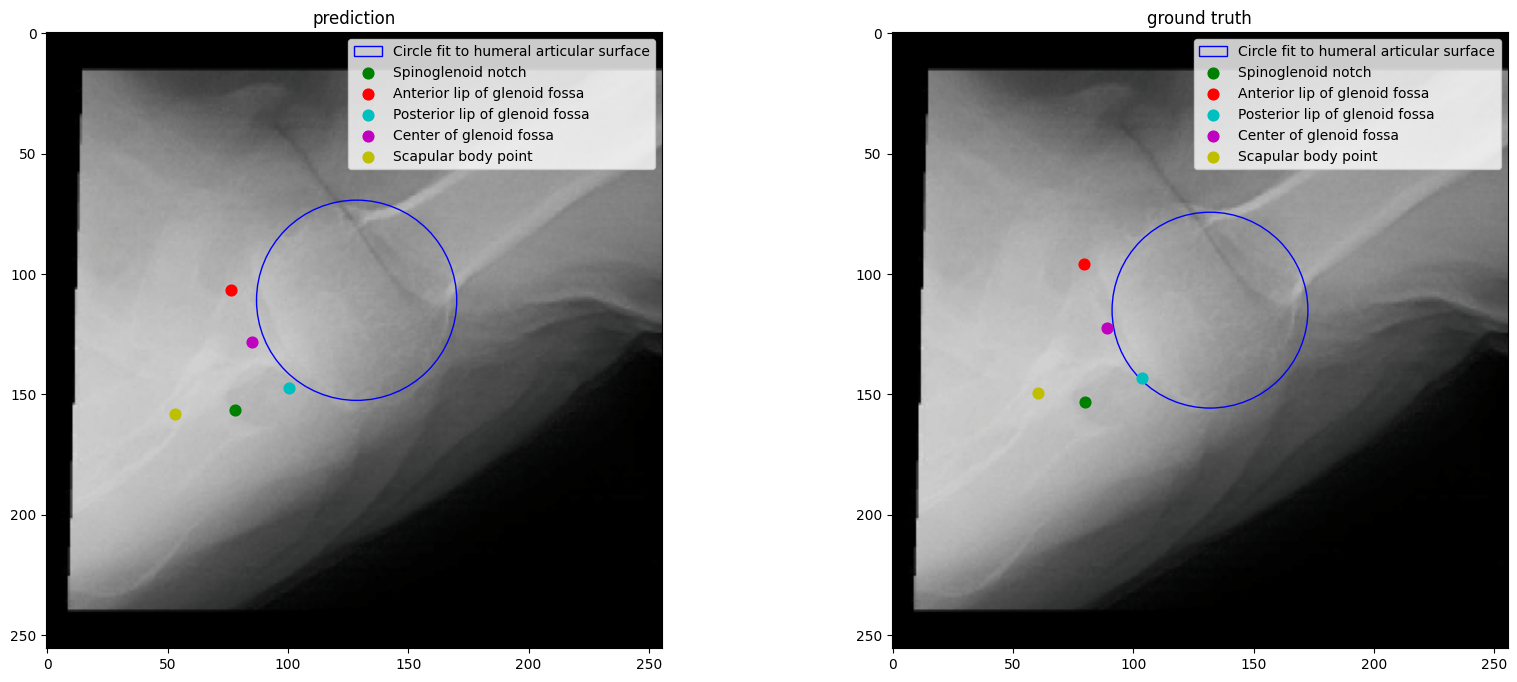

In [61]:
plt.figure(figsize=(20, 8))

# Create the first subplot on the left
plt.subplot(1, 2, 1)


draw_pred(input_img, predictions, idx, num_ell=2, num_pts=4)
plt.title("prediction")

plt.subplot(1, 2, 2)

draw_pred(input_img, true_labels, idx, num_ell=2, num_pts=4)

plt.title("ground truth")
idx+=1

In [27]:
torch.save(model, "resne34-600ep-adam")


tensor([146.9145,  98.4393,  53.7241, 189.4961, 174.0042])
tensor([142.6740,  93.4902,  59.0390, 194.3174, 173.4776])


Text(0.5, 1.0, 'ground truth')

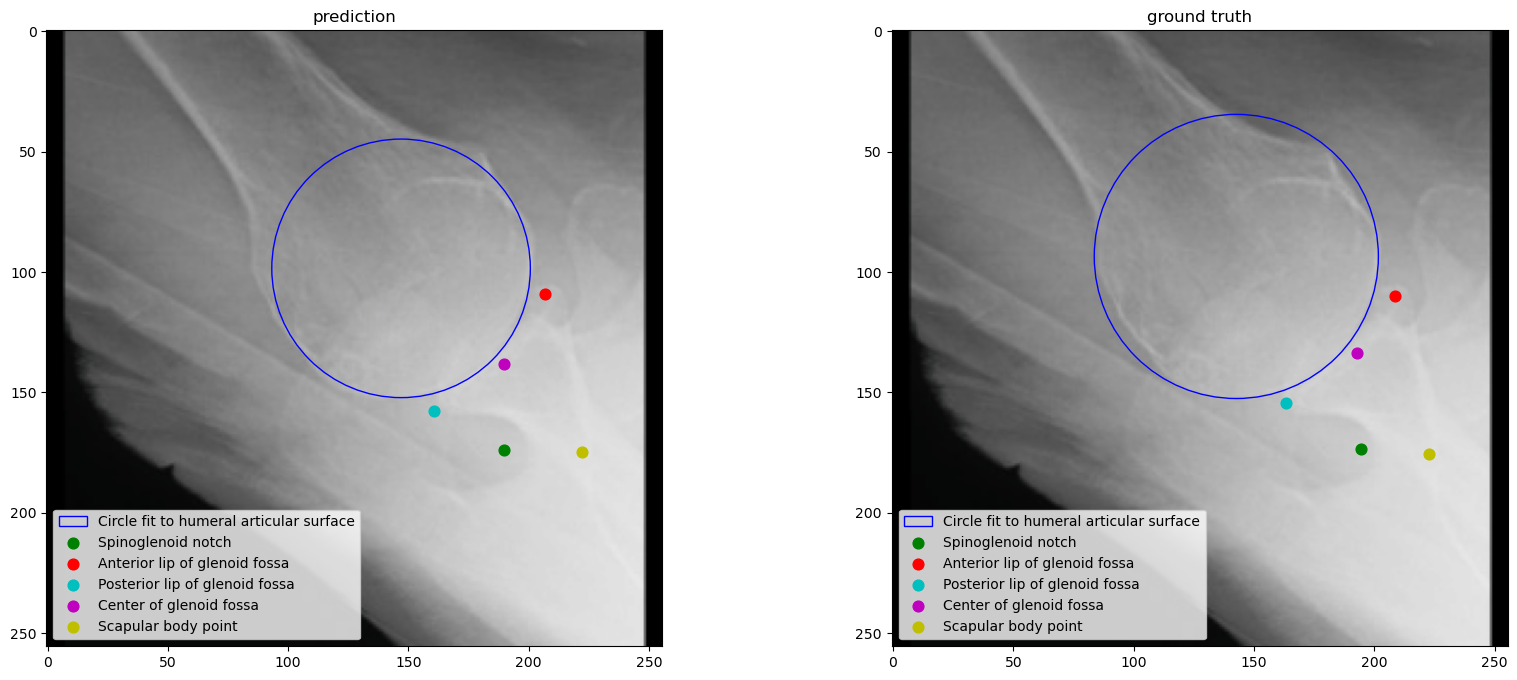

In [36]:
plt.figure(figsize=(20, 8))

# Create the first subplot on the left
plt.subplot(1, 2, 1)


draw_pred(input_img, predictions, idx, num_ell=2, num_pts=4)
plt.title("prediction")

plt.subplot(1, 2, 2)

draw_pred(input_img, true_labels, idx, num_ell=2, num_pts=4)

plt.title("ground truth")

tensor([127.8534, 115.1916,  55.7406,  66.9495, 183.3330])
tensor([136.7752, 111.7433,  64.7119,  59.3797, 178.3991])


Text(0.5, 1.0, 'ground truth')

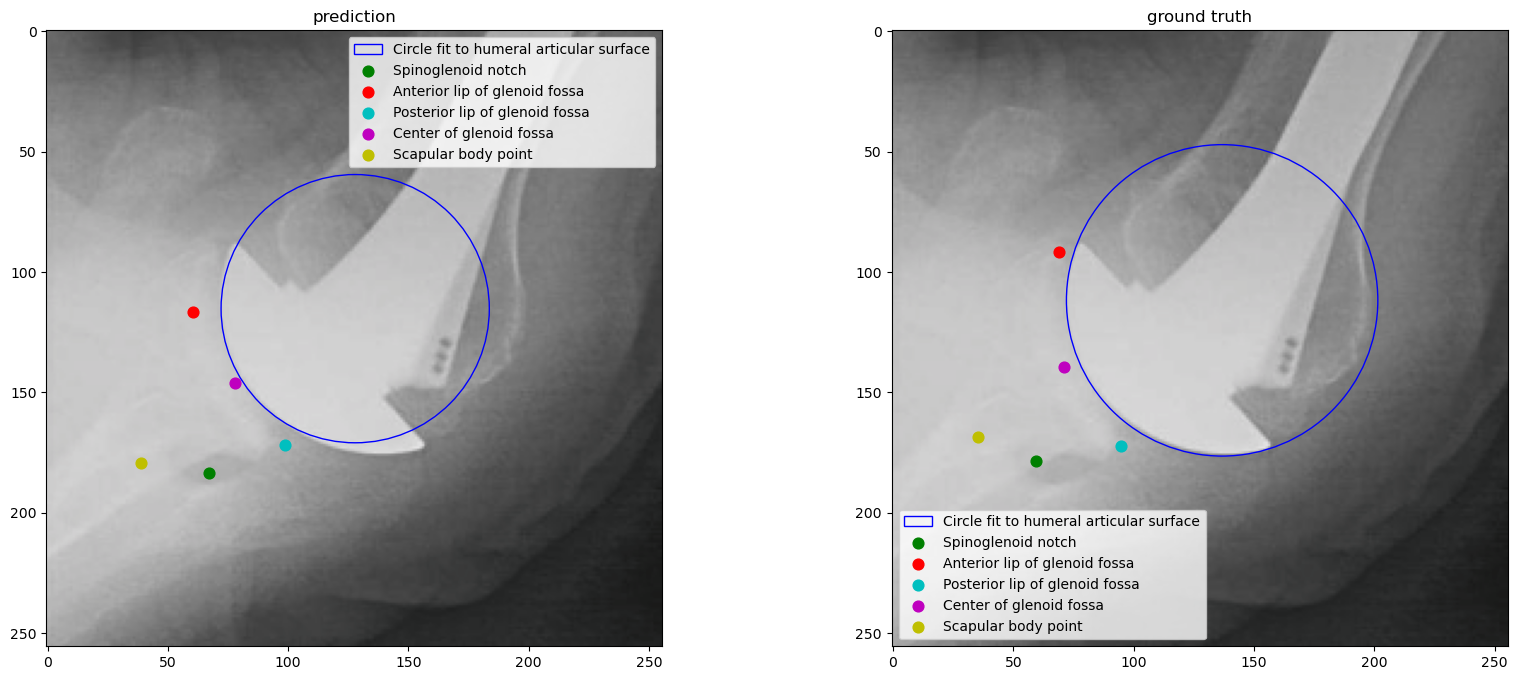

In [37]:
idx+=1
plt.figure(figsize=(20, 8))

# Create the first subplot on the left
plt.subplot(1, 2, 1)


draw_pred(input_img, predictions, idx, num_ell=2, num_pts=4)
plt.title("prediction")

plt.subplot(1, 2, 2)

draw_pred(input_img, true_labels, idx, num_ell=2, num_pts=4)

plt.title("ground truth")